In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = pyepo.model.omo.shortestPathModel(grid, solver="gurobi")
#sp_model = pyepo.model.omo.shortestPathModel(grid, solver="glpk")

Solver in the background: gurobi


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 5)
(5, 10)
(10, 15)
(15, 20)
(20, 21)
(21, 22)
(22, 23)
(23, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 241.92it/s]


In [9]:
# get test data set
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.90it/s]


In [10]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [12]:
x.shape

torch.Size([32, 5])

In [13]:
c.shape

torch.Size([32, 40])

In [14]:
w.shape

torch.Size([32, 40])

In [15]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [18]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [19]:
# training
twostage_model.fit(sp_dataset_train.feats, sp_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.feats)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.costs[i]
    z_true_i = sp_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(sp_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(sp_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.57it/s]


Normalized Regret: 1.61%
Normalized Unambiguous Regret: 1.61%


In [22]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.28, 0.16, 0.55, -0.67, 0.99, -0.21, -0.41, 0.30, -0.19, 0.41, -0.21, 0.04, -0.57, 0.30, -0.33, 0.30, -0.84, 0.20, 0.05, -0.21, 0.04, 0.20, 0.57, -0.09, 0.79, -0.41, -0.33, -0.33, 0.46, 0.55, 0.33, -0.57, 0.33, 0.16, 0.55, 0.55, -0.41, 0.55, -0.05, 0.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10

## Linear Regression from PyTorch

In [23]:
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [27]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [28]:
# train model
num_epochs = 100
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data   

Epoch   0, Loss:   0.4476, Regret:  1.9581%, Unambiguous Regret:  1.9581%
Epoch   5, Loss:   0.2181, Regret:  0.5344%, Unambiguous Regret:  0.5344%
Epoch  10, Loss:   0.0804, Regret:  0.4958%, Unambiguous Regret:  0.4958%
Epoch  15, Loss:   0.3556, Regret:  0.5125%, Unambiguous Regret:  0.5125%
Epoch  20, Loss:   0.0000, Regret:  0.5177%, Unambiguous Regret:  0.5177%
Epoch  25, Loss:   0.5209, Regret:  0.4222%, Unambiguous Regret:  0.4222%
Epoch  30, Loss:   0.0937, Regret:  0.5114%, Unambiguous Regret:  0.5114%
Epoch  35, Loss:   0.1766, Regret:  0.4536%, Unambiguous Regret:  0.4536%
Epoch  40, Loss:   0.5476, Regret:  0.5581%, Unambiguous Regret:  0.5581%
Epoch  45, Loss:   0.0601, Regret:  0.4854%, Unambiguous Regret:  0.4854%
Epoch  50, Loss:   0.0254, Regret:  0.4886%, Unambiguous Regret:  0.4886%
Epoch  55, Loss:   0.0193, Regret:  0.4634%, Unambiguous Regret:  0.4634%
Epoch  60, Loss:   0.1280, Regret:  0.4516%, Unambiguous Regret:  0.4516%
Epoch  65, Loss:   0.1132, Regret:  0.

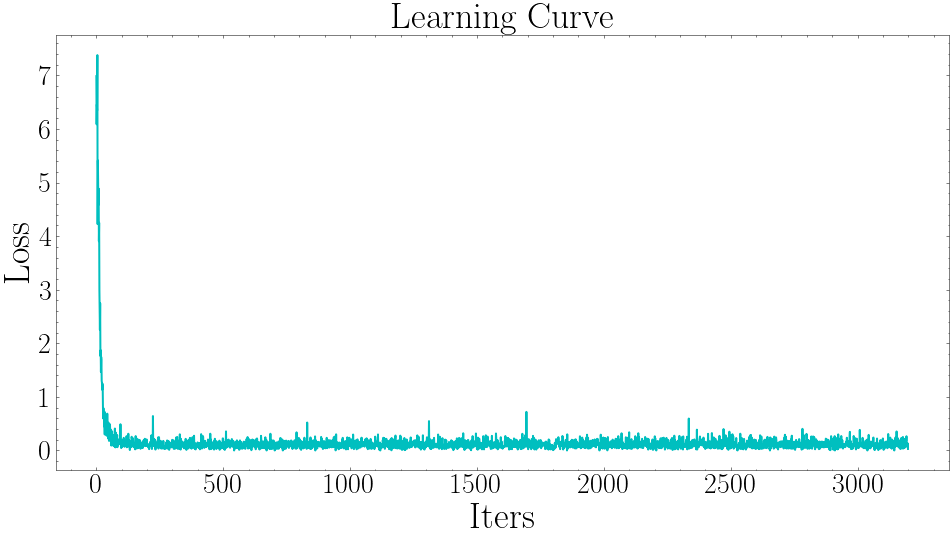

In [29]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

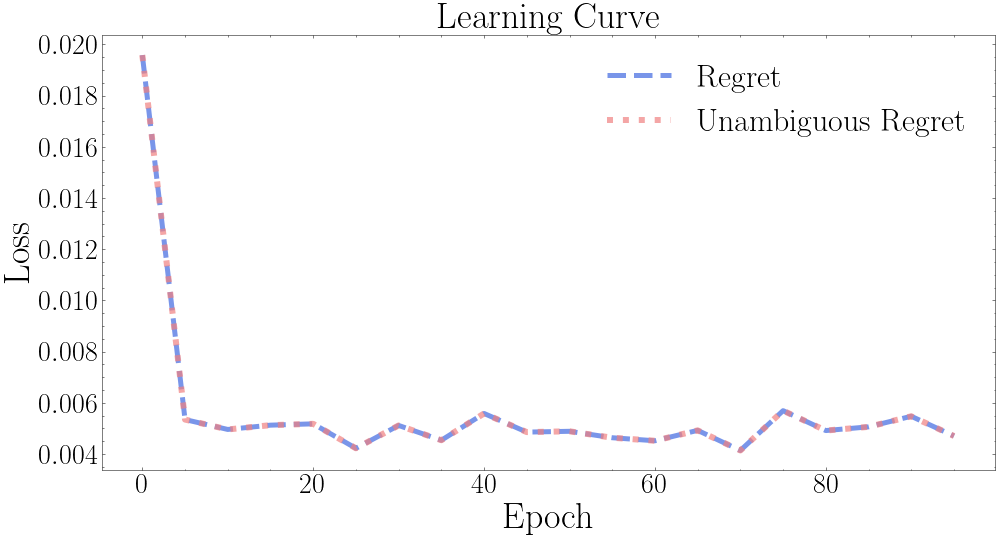

In [30]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [31]:
# evaluate
regret = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(regret * 100))
regret = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(regret * 100))

Normalized Regret: 0.46%
Normalized Unambiguous Regret: 0.46%


In [32]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -1.31, 0.12, 0.71, 0.69, 1.35, -0.21, 0.17, -0.14, -0.19, 1.52, -0.88, -0.79, -0.20, 0.85, -0.28, 1.61, -1.41, -0.93, 0.72, -0.50, -0.81, -0.62, -0.10, -0.03, -0.10, -0.62, 0.01, 0.51, -0.38, 2.20, 0.16, -0.86, -0.33, -0.85, 0.32, -0.30, 0.05, -0.34, 0.69, -0.72
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.

## Black-Box with Hamming Distance

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [35]:
# set loss
criterion = nn.L1Loss()
dbb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)

Num of cores: 4


In [36]:
# train model
num_epochs = 200
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # loss
        loss = criterion(wp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        regret = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        regret_log.append(regret)
        # unambiguous regret 
        unambregret = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        unambregret_log.append(unambregret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), regret*100, unambregret*100))

Epoch   0, Loss:   0.2250, Regret: 29.0722%, Unambiguous Regret: 29.0723%
Epoch   5, Loss:   0.1375, Regret: 11.9248%, Unambiguous Regret: 11.9248%
Epoch  10, Loss:   0.1375, Regret:  6.8464%, Unambiguous Regret:  6.8464%
Epoch  15, Loss:   0.1000, Regret:  5.1164%, Unambiguous Regret:  5.1164%
Epoch  20, Loss:   0.0750, Regret:  4.9247%, Unambiguous Regret:  4.9247%
Epoch  25, Loss:   0.1125, Regret:  3.5198%, Unambiguous Regret:  3.5198%
Epoch  30, Loss:   0.0750, Regret:  2.8324%, Unambiguous Regret:  2.8324%
Epoch  35, Loss:   0.0625, Regret:  2.7613%, Unambiguous Regret:  2.7613%
Epoch  40, Loss:   0.0875, Regret:  3.7273%, Unambiguous Regret:  3.7273%
Epoch  45, Loss:   0.0500, Regret:  3.9414%, Unambiguous Regret:  3.9414%
Epoch  50, Loss:   0.0312, Regret:  4.1331%, Unambiguous Regret:  4.1331%
Epoch  55, Loss:   0.0813, Regret:  4.8607%, Unambiguous Regret:  4.8607%
Epoch  60, Loss:   0.0625, Regret:  4.0278%, Unambiguous Regret:  4.0278%
Epoch  65, Loss:   0.1437, Regret:  3.

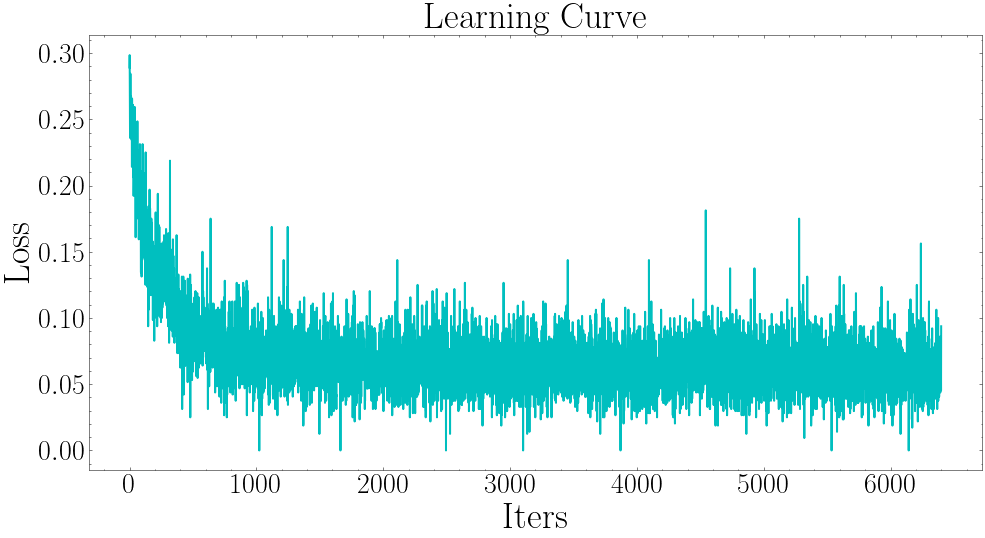

In [37]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

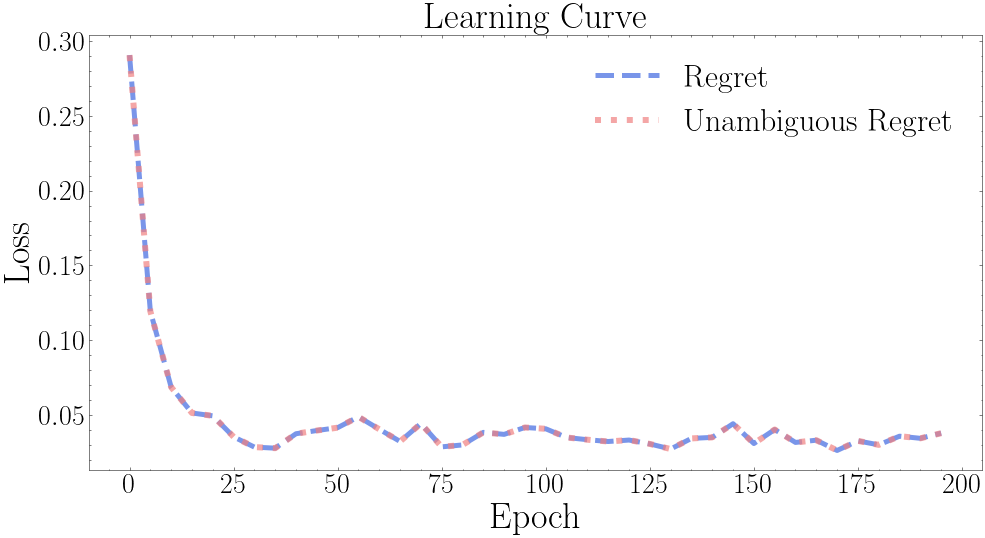

In [38]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [39]:
# evaluate
regret = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(regret * 100))
regret = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(regret * 100))

Normalized Regret: 3.11%
Normalized Unambiguous Regret: 3.11%


In [40]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -3.29, -0.02, -0.44, -1.38, 3.38, -4.15, -1.34, 0.45, 0.27, 0.68, -0.10, -2.74, 0.84, -0.14, -0.13, 2.57, -2.80, -0.09, 0.92, 0.21, -0.45, 0.26, 0.63, 0.54, 2.50, -3.34, 0.30, 0.19, 0.79, 3.66, 0.02, 1.09, 0.65, -1.54, 1.63, 0.39, -0.02, 0.08, -1.94, -0.32
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.38

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.